### Support Vector Regressor

### Step 1: Import libraries

In [1]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from math import sqrt
from joblib import Parallel, delayed
import TEpython_Parallel
import os

### Step 2: Read data (note: no explicit transformation for null model)

In [2]:
table = pd.read_csv("PRIMET_after_regression.csv", header = 0,index_col = 'DateTime',parse_dates = True, infer_datetime_format = True,low_memory=False)
# drop irrelevant columns
l1 = ['350', '250', '625_precip', 'VMC', '_ST', 'humidity', 'dewPoint', 'solar', 'Pressure', 'Deficit', 'snow', 'swe', 'VANMET', 'AirTemp'] #partial names of columns to drop
for i in l1:
    table.drop([col for col in table.columns if i in col],axis=1, inplace=True)
# calculate the 7 day rolling mean precipitation
l2 = ['PRIMET_100_precip'] # rolling average for precip data
for j in l2:
    table[j+'7d_average']=table[j].rolling(7).mean()
    table=table.drop(columns=[j])   # drop daily precipitation data 
table = table.dropna() 
table = table.loc[:,~table.columns.duplicated()] # remove duplicate discharge columns

nRows = int(table.shape[0])
nCols = int(table.shape[1])

table.head(5)


,GSLOOK_discharge,PRIMET_100_precip7d_average
DateTime,,
2001-02-27,44.0,2.071429
2001-02-28,42.0,0.871429
2001-03-01,46.0,3.342857
2001-03-02,60.0,3.300000
2001-03-03,55.0,3.300000


In [3]:
# get predictor names
colnames = list(table.columns)
varnames = colnames[1:nCols]
varnames

['PRIMET_100_precip7d_average']

### Step 3: Separate predictors and response variable, rescale predictors (sensitive to scaling method!)

In [4]:
# separate variables
discharge = table.GSLOOK_discharge.values
predictors = table.iloc[:,1:nCols].values
predictors[0,:]

array([2.07142857])

In [5]:
# rescale predictors
# X
X_unscaled = predictors
# rescale data
X = scale(X_unscaled, axis=0, with_mean=True, with_std=True, copy=True)
#X = minmax_scale(X_unscaled, feature_range=(0, 1), axis=0, copy=True)
#X = normalize(X_unscaled, norm='l2', axis=0, copy=True, return_norm=False)
#myScaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#myScaler= RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)
#X = myScaler.fit_transform(X_unscaled)
X[0,:]
print(X.shape)

(5056, 1)


In [6]:
# Y
Y = discharge
print(Y.shape)

(5056,)


### Step 4: Split data into training and test set

In [7]:
# separate train and test data
train_fraction = 0.75
train_length = int(nRows * train_fraction)
test_length = nRows-train_length
#
train_X = X[:train_length,:]
train_Y = Y[:train_length]
test_X = X[train_length:,:]
test_Y = Y[train_length:]


### Step 5: Setup cross-validation, estimator, and parameter search (COARSE)

In [8]:
# define k-fold and number of parallel jobs
nFold = 5
nJobs = 20

In [9]:
# setup default estimator (Python implementation of LibSVM, uses MSE as default metric)
mySVR = svm.SVR(kernel="rbf",max_iter=-1, verbose=3)

## Important parameters (note: many possible kernels, must satisfy f(xy) = f(x)f(y)):

kernel : string, optional (default=’rbf’)

    Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. 
    
degree : int, optional (default=3)

    Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
gamma : float, optional (default=’auto’)

    Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

C : float, optional (default=1.0)

    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)

    Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [10]:
# setup brute force coarse parameter search (spaced at 0.5 log2 intervals)
C_list_coarse = list(np.logspace(-5, 5, num=21, endpoint=True, base=2.0, dtype=None))
E_list_coarse = list(np.logspace(-5, 5, num=21, endpoint=True, base=2.0, dtype=None))
G_list_coarse = list(np.logspace(-5, 5, num=21, endpoint=True, base=2.0, dtype=None))
mySVR_params = {'C':C_list_coarse, 'epsilon':E_list_coarse, 'gamma':G_list_coarse}
mySVR_params

{'C': [0.03125,
  0.04419417382415922,
  0.0625,
  0.08838834764831845,
  0.125,
  0.1767766952966369,
  0.25,
  0.3535533905932738,
  0.5,
  0.7071067811865476,
  1.0,
  1.4142135623730951,
  2.0,
  2.8284271247461903,
  4.0,
  5.656854249492381,
  8.0,
  11.313708498984761,
  16.0,
  22.627416997969522,
  32.0],
 'epsilon': [0.03125,
  0.04419417382415922,
  0.0625,
  0.08838834764831845,
  0.125,
  0.1767766952966369,
  0.25,
  0.3535533905932738,
  0.5,
  0.7071067811865476,
  1.0,
  1.4142135623730951,
  2.0,
  2.8284271247461903,
  4.0,
  5.656854249492381,
  8.0,
  11.313708498984761,
  16.0,
  22.627416997969522,
  32.0],
 'gamma': [0.03125,
  0.04419417382415922,
  0.0625,
  0.08838834764831845,
  0.125,
  0.1767766952966369,
  0.25,
  0.3535533905932738,
  0.5,
  0.7071067811865476,
  1.0,
  1.4142135623730951,
  2.0,
  2.8284271247461903,
  4.0,
  5.656854249492381,
  8.0,
  11.313708498984761,
  16.0,
  22.627416997969522,
  32.0]}

### Step 6: Perform parameter search, fit estimator (COARSE)

In [14]:
# do parameter space search
# GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=’warn’)
mySVR_coarse = GridSearchCV(mySVR, mySVR_params, cv=nFold, n_jobs=nJobs, refit=True, verbose=3)
mySVR_coarse.fit(train_X, train_Y)


Fitting 5 folds for each of 9261 candidates, totalling 46305 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   36.5s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  3.1min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  4.5min
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:  6.2min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:  8.0min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed: 10.0min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 12.4min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed: 15.4min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed: 17.8min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed: 20.9min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed: 24.0min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 27.5min
[Parallel(n_jobs=20)]: Done 8152 tasks      |

[LibSVM]

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001, verbose=3),
             iid='warn', n_jobs=20,
             param_grid={'C': [0.03125, 0.04419417382415922, 0.0625,
                               0.08838834764831845, 0.125, 0.1767766952966369,
                               0.25, 0.3535533905932738, 0.5,
                               0.7...
                                     22.627416997969522, 32.0],
                         'gamma': [0.03125, 0.04419417382415922, 0.0625,
                                   0.08838834764831845, 0.125,
                                   0.1767766952966369, 0.25, 0.3535533905932738,
                                   0.5, 0.7071067811865476, 1.0,
                                   1.4142135623730951, 2.0, 2.8284271247461903,
         

In [11]:
#% store mySVR_coarse # this saves the variable from the coarse parameter search that took forever
% store -r mySVR_coarse # this refreshes the stored variable, you will need to re-run steps 1-5
mySVR_coarse.best_params_

no stored variable # this refreshes the stored variable, you will need to re-run steps 1-5


{'C': 32.0, 'epsilon': 32.0, 'gamma': 0.25}

### Step 7: Train and test using optimized estimator (coarse)

In [12]:
# train and test
mySVR_test_pred = mySVR_coarse.predict(test_X)
mySVR_train_pred = mySVR_coarse.predict(train_X)


### Step 8: Compute error

In [13]:
def logNS(o,s):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    eps = 1e-5
    return 1 - sum((np.log(s+eps)-np.log(o+eps))**2)/sum((np.log(o+eps)-np.mean(np.log(o+eps)))**2) 

# compute error
RMSE = np.sqrt(metrics.mean_squared_error(test_Y, mySVR_test_pred))
EVS = metrics.explained_variance_score(test_Y, mySVR_test_pred)
R2 = metrics.r2_score(test_Y, mySVR_test_pred)
NS = logNS(test_Y, mySVR_test_pred)

print('RMSE:', RMSE)
print('EVS:', EVS)
print('R2:', R2)
print('NS:', NS)

RMSE: 146.88991107719949
EVS: 0.4806887006956867
R2: 0.47225577335712043
NS: 0.4787788001565122


### Step 9: plot results

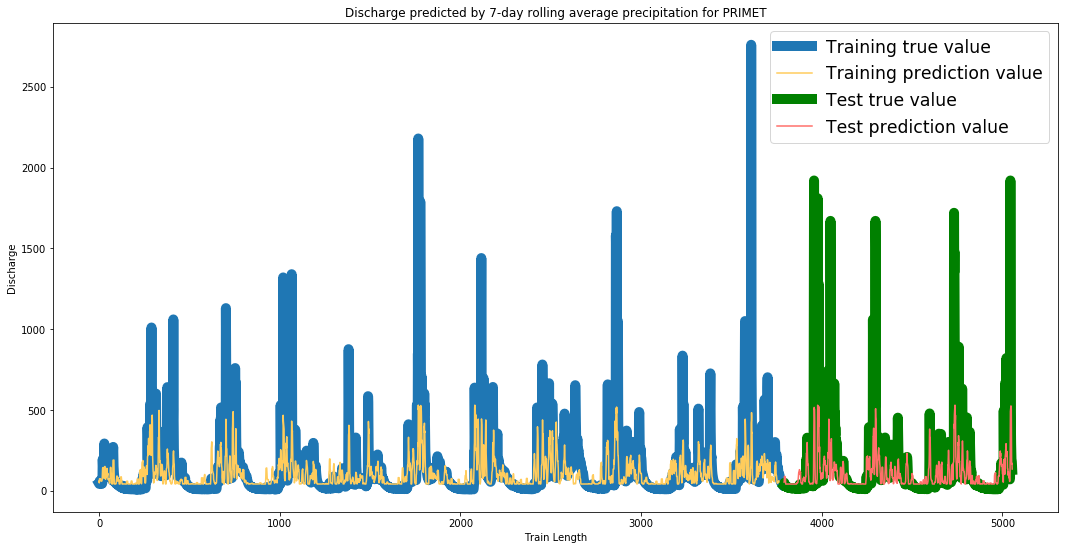

In [25]:
# plot
plt.figure(figsize=(18,9))
plt.plot(np.arange(train_length), train_Y, label='Training true value', lw=10)
plt.plot(np.arange(train_length), mySVR_train_pred, label='Training prediction value', color='#ffcc5c')
plt.plot(np.arange(train_length,nRows), test_Y, label='Test true value', lw=10, c='g')
plt.plot(np.arange(train_length,nRows), mySVR_test_pred, label='Test prediction value', color='#ff6f69')
plt.ylabel("Discharge")
plt.xlabel("Train Length")
plt.title('Discharge predicted by 7-day rolling average precipitation for PRIMET')
plt.legend(fontsize='xx-large')


### Step 10: refine search around best coarse parameters

In [14]:
# now look at best parameters and setup fine search
BestCoarseC = mySVR_coarse.best_params_['C']
BestCoarseE = mySVR_coarse.best_params_['epsilon']
BestCoarseG = mySVR_coarse.best_params_['gamma']

# space at 1/10 of the coarse interval .5 -> .05 (in log2 space)C_list_fine = list(np.logspace(np.log2(BestCoarseC)-0.45, np.log2(BestCoarseC)+0.45, num=19, endpoint=True, base=2.0, dtype=None))
C_list_fine = list(np.logspace(np.log2(BestCoarseC)-0.45, np.log2(BestCoarseC)+0.45, num=21, endpoint=True, base=2.0, dtype=None))
E_list_fine = list(np.logspace(np.log2(BestCoarseE)-0.45, np.log2(BestCoarseE)+0.45, num=21, endpoint=True, base=2.0, dtype=None))
G_list_fine = list(np.logspace(np.log2(BestCoarseG)-0.45, np.log2(BestCoarseG)+0.45, num=21, endpoint=True, base=2.0, dtype=None))
mySVR_params = {'C':C_list_fine, 'epsilon':E_list_fine, 'gamma':G_list_fine}

In [ ]:
# perform fine parameter space search
# GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=’warn’)
mySVR_fine = GridSearchCV(mySVR, mySVR_params, cv=nFold, n_jobs=nJobs, refit=True, verbose=3)
mySVR_fine.fit(train_X, train_Y)

Fitting 5 folds for each of 9261 candidates, totalling 46305 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   28.4s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   55.5s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:  4.1min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:  5.1min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:  6.4min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  7.9min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed:  9.4min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed: 11.2min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed: 13.6min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed: 15.7min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 18.5min
[Parallel(n_jobs=20)]: Done 8152 tasks      |

In [26]:
% store mySVR_fine
#% store -r mySVR_fine
mySVR_fine.best_params_

{'C': 43.71328821614066,
 'epsilon': 33.458148670888484,
 'gamma': 0.16575713266603045}

### Step 11: Train and test using optimized estimator (fine)

In [27]:
# train and test
mySVR_test_pred = mySVR_fine.predict(test_X)
mySVR_train_pred = mySVR_fine.predict(train_X)

# eliminate negative predictions
mySVR_train_pred_copy = mySVR_train_pred.copy()
mySVR_test_pred_copy = mySVR_test_pred.copy()
mySVR_test_pred[mySVR_test_pred<0] = 0
mySVR_train_pred[mySVR_train_pred<0] = 0

BestFineC = mySVR_fine.best_params_['C']
BestFineE = mySVR_fine.best_params_['epsilon']
BestFineG = mySVR_fine.best_params_['gamma']


### Step 12: Compute error (note: different ranking for different metrics)

In [28]:
def logNS(o,s):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    eps = 1e-5
    return 1 - sum((np.log(s+eps)-np.log(o+eps))**2)/sum((np.log(o+eps)-np.mean(np.log(o+eps)))**2) 

# compute error
RMSE = np.sqrt(metrics.mean_squared_error(test_Y, mySVR_test_pred))
EVS = metrics.explained_variance_score(test_Y, mySVR_test_pred)
R2 = metrics.r2_score(test_Y, mySVR_test_pred)
NS = logNS(test_Y, mySVR_test_pred)

print('RMSE:', RMSE)
print('EVS:', EVS)
print('R2:', R2)
print('NS:', NS)

RMSE: 145.1447859036604
EVS: 0.4914807128000802
R2: 0.4847210118451857
NS: 0.46853300750960125


### Step13: plot results (fine)

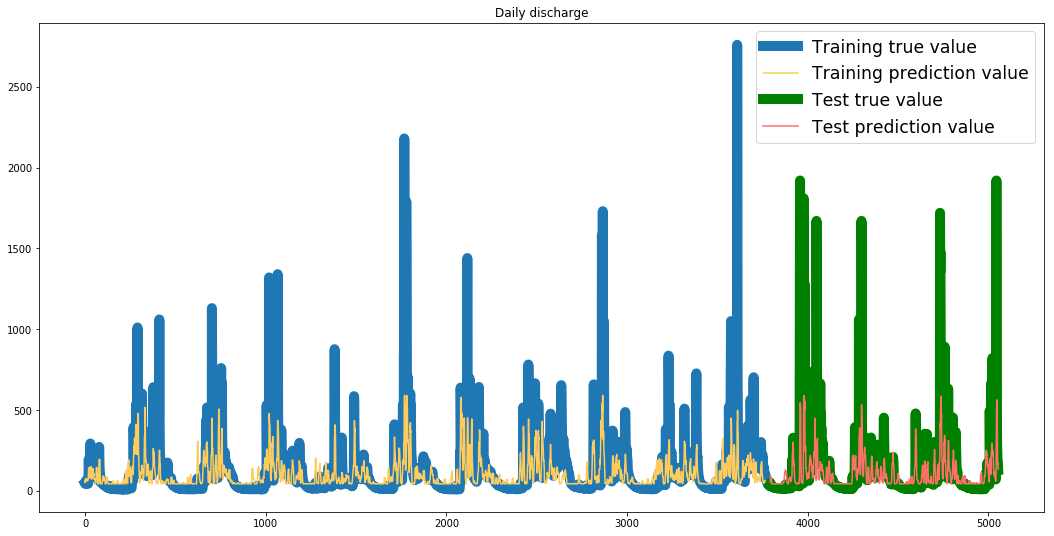

In [29]:
plt.figure(figsize=(18,9))
plt.plot(np.arange(train_length), train_Y, label='Training true value', lw=10)
plt.plot(np.arange(train_length), mySVR_train_pred, label='Training prediction value', color='#ffcc5c')
plt.plot(np.arange(train_length,nRows), test_Y, label='Test true value', lw=10, c='g')
plt.plot(np.arange(train_length,nRows), mySVR_test_pred, label='Test prediction value', color='#ff6f69')
plt.ylab("Discharge")
plt.xlab("Train Length")
plt.title('Discharge predicted by 7-day rolling average precipitation for PRIMET')
plt.legend(fontsize='xx-large')


### Step 14: compute Mutual Information between observed and model

In [31]:
# stack observed and model into a matrix
DataMat = np.column_stack((test_Y,mySVR_test_pred))

# compute mutual information
nbins = [11,11,11]
MutInfoQobsVSQmod = TEpython_Parallel.mutinfo_new(DataMat,nbins)
print('Mutual Information, I = ', MutInfoQobsVSQmod*100, '%') # I/H

Mutual Information, I =  23.632912745437714 %
